In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset

In [4]:
df_price = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bert/AAPL_price.csv", sep=',', decimal=',',  parse_dates=['time'])
df_price['time'] = df_price['time'].dt.date
df_price = df_price.loc[:, ['time', 'median']]
df_price['median'] = df_price['median'].astype(float)
df_price['median_5_days'] = (df_price['median'].shift(1,fill_value=0) + 
                              df_price['median'].shift(2,fill_value=0) + 
                              df_price['median'].shift(3,fill_value=0) +
                              df_price['median'].shift(4,fill_value=0) +
                              df_price['median'].shift(5,fill_value=0)) / 5

df_price.loc[0:4, 'median_5_days'] = None
df_price['diff_medians'] = df_price['median'] - df_price['median_5_days']
df_price['diff_medians%'] = (df_price['diff_medians'] / df_price['median_5_days']) * 100
df_price.dropna(inplace=True)
df_price

time      median  median_5_days  diff_medians  diff_medians%
5    2021-04-09  132.070007     126.463318      5.606689       4.433451
6    2021-04-12  131.309998     128.277319      3.032678       2.364158
7    2021-04-13  134.119995     129.408319      4.711676       3.640938
8    2021-04-14  132.899994     130.948318      1.951675       1.490417
9    2021-04-15  134.499893     132.084018      2.415875       1.829044
..          ...         ...            ...           ...            ...
263  2022-04-18  164.820007     168.429858     -3.609851      -2.143237
264  2022-04-19  166.500000     167.245859     -0.745859      -0.445965
265  2022-04-20  167.229996     167.249860     -0.019864      -0.011877
266  2022-04-21  168.970001     167.123859      1.846143       1.104655
267  2022-04-22  164.070007     166.837860     -2.767853      -1.659008

[263 rows x 5 columns]

In [5]:
df_price[df_price['diff_medians%'] == df_price['diff_medians%'].max()]

time      median  median_5_days  diff_medians  diff_medians%
210  2022-01-31  173.029999      161.57464     11.455359       7.089825

In [6]:
df_price[df_price['diff_medians%'] == df_price['diff_medians%'].min()]

time      median  median_5_days  diff_medians  diff_medians%
205  2022-01-24  158.350006        168.278     -9.927994      -5.899757

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Difference of the median %')

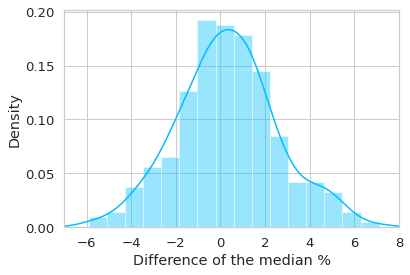

In [7]:
sns.distplot(df_price['diff_medians%'])
plt.xlim([-7, 8]);
plt.xlabel('Difference of the median %')

In [8]:
# 0.25
percentiles_25 = df_price['diff_medians%'].quantile([0.25]).values[0]  
percentiles_25

-1.0432840098959182

In [9]:
# 0.75
percentiles_75 = df_price['diff_medians%'].quantile([.75]).values[0]
percentiles_75

1.632770822006605

In [10]:
conditions = [
    (df_price['diff_medians%'] >= percentiles_75),
    (df_price['diff_medians%'] < percentiles_75) & (df_price['diff_medians%'] > percentiles_25),
    (df_price['diff_medians%'] <= percentiles_25)]

# create a list of the values we want to assign for each condition
values = [1, 0, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df_price['label'] =  np.select(conditions, values)
df_price

time      median  median_5_days  diff_medians  diff_medians%  label
5    2021-04-09  132.070007     126.463318      5.606689       4.433451      1
6    2021-04-12  131.309998     128.277319      3.032678       2.364158      1
7    2021-04-13  134.119995     129.408319      4.711676       3.640938      1
8    2021-04-14  132.899994     130.948318      1.951675       1.490417      0
9    2021-04-15  134.499893     132.084018      2.415875       1.829044      1
..          ...         ...            ...           ...            ...    ...
263  2022-04-18  164.820007     168.429858     -3.609851      -2.143237      2
264  2022-04-19  166.500000     167.245859     -0.745859      -0.445965      0
265  2022-04-20  167.229996     167.249860     -0.019864      -0.011877      0
266  2022-04-21  168.970001     167.123859      1.846143       1.104655      0
267  2022-04-22  164.070007     166.837860     -2.767853      -1.659008      2

[263 rows x 6 columns]

In [11]:
df_news = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bert/AAPL.csv', sep=',', decimal=',',  index_col=0)
df_news

ticker                 date        source  \
0       AAPL  2021-04-27 00:00:00        PR Web   
1       AAPL  2021-04-27 00:00:00        PR Web   
2       AAPL  2021-04-27 00:00:00        PR Web   
3       AAPL  2021-04-27 00:00:00        PR Web   
4       AAPL  2021-04-27 00:00:00        PR Web   
...      ...                  ...           ...   
17216   AAPL  2022-04-22 08:23:00         Yahoo   
17217   AAPL  2022-04-22 07:30:00  SeekingAlpha   
17218   AAPL  2022-04-22 06:20:00        Nasdaq   
17219   AAPL  2022-04-22 05:29:02       Finnhub   
17220   AAPL  2022-04-22 04:22:00  SeekingAlpha   

                                                   title  \
0      Meoshi Crumedy's newly released "Shut Up and P...   
1      Robert Davis's newly released "Finding God's P...   
2      Dominic Murgido's newly released "Miss Your Fo...   
3      Nicholas Williams' newly released "How to Live...   
4      Author Jackie Glanton's newly released "Blood ...   
...                                                  ...   
17216  Meta Stock Rises, Pinterest Slips After User G...   
17217  Why Netflix's Problems Are Independent Of The ...   
17218  Should Motley Fool 100 Index ETF (TMFC) Be on ...   
17219    Take Five: April showers earnings and elections   
17220  RiverPark Long/Short Opportunity Fund Q1 2022 ...   

                                             description  \
0      Looking for stock market analysis and research...   
1      Looking for stock market analysis and research...   
2      Looking for stock market analysis and research...   
3      Looking for stock market analysis and research...   
4      Looking for stock market analysis and research...   
...                                                  ...   
17216  Daily active users in the first quarter at Sna...   
17217  Streaming is not dying as a medium - it is evo...   
17218  The Motley Fool 100 Index ETF (TMFC) was launc...   
17219  From HSBC and Volvo in Europe to Apple and McD...   
17220  RiverPark Long/Short Opportunity Fund trades a...   

                                                     url  
0      https://finnhub.io/api/news?id=5f13bfb3bf420bd...  
1      https://finnhub.io/api/news?id=6bbeb56b97bc086...  
2      https://finnhub.io/api/news?id=9045fa062014155...  
3      https://finnhub.io/api/news?id=160d8d4c66033aa...  
4      https://finnhub.io/api/news?id=49ca1e1b3bdb6cb...  
...                                                  ...  
17216  https://finnhub.io/api/news?id=05e9df27e4139b4...  
17217  https://finnhub.io/api/news?id=eacacee5eaafad2...  
17218  https://finnhub.io/api/news?id=8f88f0f4c4dbefb...  
17219  https://finnhub.io/api/news?id=83c9a077f048aea...  
17220  https://finnhub.io/api/news?id=a427f1c2bf72cfc...  

[17221 rows x 6 columns]

In [12]:
df_news['date'] = pd.to_datetime(df_news['date'], format="%Y/%m/%d")
df_news['date'] = df_news['date'].dt.date

In [13]:
#  1 вариант
# df_news = df_news[~df_news.source.isin(["PR Web", "PR Newswire"])]

df_news = df_news[df_news.source.isin(["Reuters", "Yahoo", "Nasdaq", "SeekingAlpha", "CNBC"])]
# df_news = df_news[df_news.source.isin(["Reuters"])]

In [14]:
df_news = df_news.dropna()

In [15]:
# arrange punctuation marks
def text_preprocessing(text):
    if str(text)[-1] not in ['.', '?', '!']:
        text += "."
    return text

In [16]:
df_news['title'] = df_news['title'].apply(text_preprocessing)
df_news['description'] = df_news['description'].apply(text_preprocessing)

In [17]:
df1 = df_news.groupby(['date'])['title'].apply(lambda x: ''.join(x.astype(str))).reset_index()
df2 = df_news.groupby(['date'])['description'].apply(lambda x: ''.join(x.astype(str))).reset_index()
df_news = pd.merge(df1, df2, how='inner', on='date')

In [18]:
len(df_news)

362

In [19]:
df_news.rename(columns={'date': 'time'}, inplace=True)
df_news.set_index('time', inplace=True)
df_news.head(5)

title  \
time                                                            
2020-06-08  5G Stocks To Buy And Watch: Pricing of 5G Smar...   
2021-04-23  4 Dow Jones Stocks To Buy And Watch In April 2...   
2021-04-27  GLOBAL MARKETS-Asian shares mixed as earnings ...   
2021-04-28  Apple: Another Massive Blowout.Apple soars pas...   
2021-04-29  Apple Earnings Were Spectacular. Why Its Stock...   

                                                  description  
time                                                           
2020-06-08  The best 5G stocks to invest in will change ov...  
2021-04-23  The Dow Jones Industrial Average remain near r...  
2021-04-27  Asian shares were mixed on Wednesday as alread...  
2021-04-28  Apples' extremely strong earnings report shoul...  
2021-04-29  Both profits and revenues were far higher than...

In [20]:
df_price.set_index('time', inplace=True)
common_df = pd.merge(df_price, df_news, how='inner', left_index=True, right_index=True)

In [21]:
df = common_df[['title', 'description', 'label']]
df

title  \
time                                                            
2021-04-23  4 Dow Jones Stocks To Buy And Watch In April 2...   
2021-04-27  GLOBAL MARKETS-Asian shares mixed as earnings ...   
2021-04-28  Apple: Another Massive Blowout.Apple soars pas...   
2021-04-29  Apple Earnings Were Spectacular. Why Its Stock...   
2021-04-30  Tech’s Big Five Had Fantastic Pandemics. Here ...   
...                                                       ...   
2022-04-18  POLL-Taiwan March export orders seen growing f...   
2022-04-19  How did Netflix lose subscribers in 2022?Apple...   
2022-04-20  Apple Faces New In-Store Labor Drive as Union ...   
2022-04-21  Heading Into Its Q3, Is Microsoft (MSFT) A Buy...   
2022-04-22  The Entire AirPods Family is Discounted on Ama...   

                                                  description  label  
time                                                                  
2021-04-23  The Dow Jones Industrial Average remain near r...      0  
2021-04-27  Asian shares were mixed on Wednesday as alread...      0  
2021-04-28  Apples' extremely strong earnings report shoul...      0  
2021-04-29  Both profits and revenues were far higher than...      0  
2021-04-30  Alphabet, Amazon.com, Apple, Facebook, and Mic...      2  
...                                                       ...    ...  
2022-04-18  Taiwan's export orders likely rose in March fo...      2  
2022-04-19  Netflix's pandemic party gains seem to be over...      0  
2022-04-20  (Bloomberg Law) -- Workers at an Apple Inc.sto...      0  
2022-04-21  Tech stocks have tumbled year-to-date, with ma...      0  
2022-04-22  Regardless of the model, all AirPods deliver r...      2  

[252 rows x 3 columns]

In [22]:
len(df)

252

In [23]:
# df['title'] = df['title'].astype(str)
# df['description'] = df['description'].astype(str)
# df['label'] = df['label'].astype(str)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'neutral'), Text(0, 0, 'positive'), Text(0, 0, 'negative')]

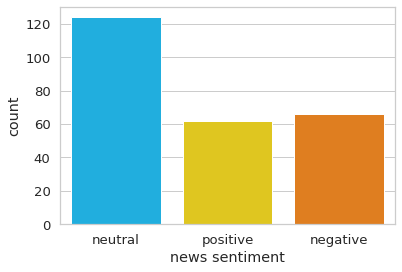

In [24]:
class_names = ["neutral", "positive", "negative"]
ax = sns.countplot(df.label)
plt.xlabel('news sentiment')
ax.set_xticklabels(class_names)


Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

Runtime -> Change runtime type -> Hardware accelerator: GPU

Then we need to run the following cell to specify the GPU as the device.

In [25]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


D - Fine-tuning BERT

Install the Hugging Face Library
The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [26]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 12.1 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 6.6 MB 30.8 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


BERT Tokenizer

In [27]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [28]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [29]:
news = list(df_news['title'])[32]
# Print the original sentence.
print('Original: ', news)

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(news))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(news)))

Original:  EXCLUSIVE-Hyundai to slash combustion engine line-up, invest in EVs - sources.GLOBAL MARKETS-Equities, yields rise as U.S. data shows economy gaining momentum.After Hours Most Active for May 27, 2021 :  CSCO, KO, GE, PG, LI, PFE, AAPL, XOM, WFC, TXN, INTC, HST.7 Best Cyclical Stocks to Go on the Defensive.Noteworthy Thursday Option Activity: AAPL, SEAS, BLUE.5 Tech Stocks That Bargain Hunters Will Love.A Look At Yield On Cost - April Dividend Income Report.Here's Why Apple May Embrace Cryptocurrency.July 9th Options Now Available For Apple.Germany, France, Dutch want more say over tech giants' start-up deals.SPY, AZAL: Big ETF Outflows.US STOCKS-Dow set for higher open as jobless claims dip.US STOCKS-Futures dip ahead of weekly jobless claims data.
Tokenized:  ['exclusive', '-', 'hyundai', 'to', 'slash', 'combustion', 'engine', 'line', '-', 'up', ',', 'invest', 'in', 'ev', '##s', '-', 'sources', '.', 'global', 'markets', '-', 'e', '##qui', '##ties', ',', 'yields', 'rise', 'a

Choosing Sequence Length

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each news:

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

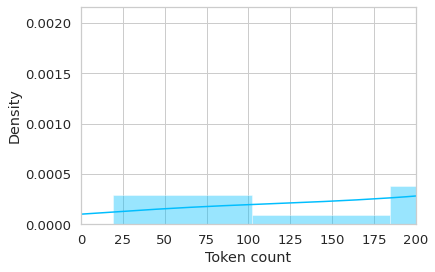

In [30]:
token_lens = []
for txt in df.title:
    tokens = tokenizer.encode(txt, max_length=1512)
    token_lens.append(len(tokens))
 
sns.distplot(token_lens)
plt.xlim([0,200])
plt.xlabel('Token count')

In [31]:
print('Max length: ', max(token_lens))

Max length:  1512


In [32]:
MAX_LEN = 512

In [33]:
class NewsDataset(Dataset):
  def __init__(self, news, targets, tokenizer, max_len):
    self.news = news
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.news)

  def __getitem__(self, item):
    new = str(self.news[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      new,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt', # Return PyTorch tensors
    )

    return {
      'news_text': new,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

 Let’s split the data

In [34]:
df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.9,random_state=42)
df_train.shape, df_val.shape

((126, 3), (12, 3))

In [35]:
# from imblearn.over_sampling import SMOTE  

# smote = SMOTE('minority')
# x_train, y_train = smote.fit_resample(df_train['title'], df_train['label'])
# df_train, df_test = smote.fit_resample(df_train, df_test)
# x_train.shape, y_train.shape

Analyze by TITLE

In [36]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = NewsDataset(
    news=df.title.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Sentiment Classification with BERT and Hugging Face

In [37]:
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup

In [38]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
      super(SentimentClassifier, self).__init__()
      self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
      self.drop = nn.Dropout(p=0.3)
      self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
      _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=False
      )
      output = self.drop(pooled_output)
      return self.out(output)

Training

In [40]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
      
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [41]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
      for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [42]:
torch.cuda.empty_cache()

In [43]:
class_names = ["neutral", "positive", "negative"]
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [45]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

436

In [46]:
%%time
history = defaultdict(list)
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
  print(f'Val loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

Epoch 1/1
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 1.123504597407121 accuracy 0.4603174603174603
Val loss 0.9955990612506866 accuracy 0.6666666666666666
CPU times: user 23.1 s, sys: 337 ms, total: 23.4 s
Wall time: 28.8 s


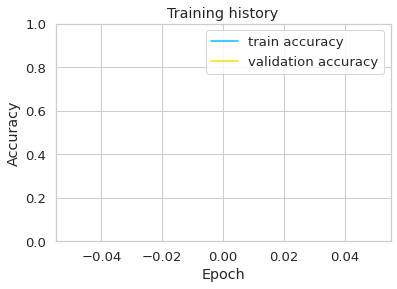

In [47]:
plt.plot([i.item() for i in history['train_acc']], label='train accuracy')
plt.plot([i.item() for i in history['val_acc']], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

calculating the accuracy on the test data:

In [48]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.49122807017543857

In [49]:
def get_predictions(model, data_loader):
    model = model.eval()
    news = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
      for d in data_loader:
        texts = d["news_text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        news.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return news, predictions, prediction_probs, real_values

In [50]:
news, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [51]:
from sklearn.metrics import confusion_matrix, classification_report

In [52]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     neutral       0.49      1.00      0.66        56
    positive       0.00      0.00      0.00        29
    negative       0.00      0.00      0.00        29

    accuracy                           0.49       114
   macro avg       0.16      0.33      0.22       114
weighted avg       0.24      0.49      0.32       114



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


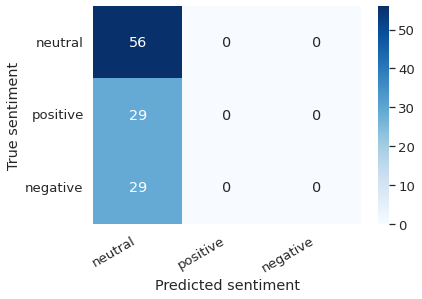

In [53]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

    
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [58]:
from sklearn import preprocessing

y = preprocessing.label_binarize(y_test, classes=[0, 1, 2])

In [59]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y[:, i],  y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

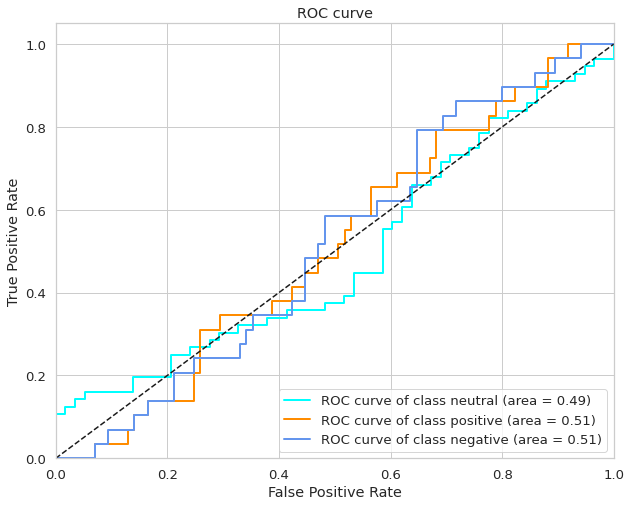

In [78]:
from itertools import cycle

n_classes = 3

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure()
plt.rcParams["figure.figsize"] = (15, 8)

classes = {0: 'neutral', 1: 'positive', 2: 'negative'}

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()
